In [1]:
import $ivy.`com.stripe::rainier-core:0.3.2`
import $ivy.`com.stripe::rainier-notebook:0.3.2`

Downloaded https://repo1.maven.org/maven2/com/stripe/rainier-core_2.12/0.3.2/rainier-core_2.12-0.3.2.pom
Downloaded https://repo1.maven.org/maven2/com/stripe/rainier-core_2.12/0.3.2/rainier-core_2.12-0.3.2.pom.sha1
Downloaded https://dl.bintray.com/cibotech/public/com/stripe/rainier-core_2.12/0.3.2/rainier-core_2.12-0.3.2.pom
Downloaded https://dl.bintray.com/cibotech/public/com/stripe/rainier-core_2.12/0.3.2/rainier-core_2.12-0.3.2.pom.sha1
Downloaded https://dl.bintray.com/rainier/maven/com/stripe/rainier-core_2.12/0.3.2/rainier-core_2.12-0.3.2.pom
Downloaded https://repo1.maven.org/maven2/com/stripe/rainier-compute_2.12/0.3.2/rainier-compute_2.12-0.3.2.pom
Downloaded https://repo1.maven.org/maven2/com/stripe/rainier-sampler_2.12/0.3.2/rainier-sampler_2.12-0.3.2.pom
Downloaded https://repo1.maven.org/maven2/com/stripe/rainier-compute_2.12/0.3.2/rainier-compute_2.12-0.3.2.pom.sha1
Downloaded https://dl.bintray.com/cibotech/public/com/stripe/rainier-compute_2.12/0.3.2/rainier-compute_2

Downloaded https://repo1.maven.org/maven2/com/google/flogger/flogger-system-backend/0.3.1/flogger-system-backend-0.3.1-sources.jar
Downloaded https://dl.bintray.com/rainier/maven/com/stripe/rainier-sampler_2.12/0.3.2/rainier-sampler_2.12-0.3.2.jar
Downloaded https://repo1.maven.org/maven2/com/google/flogger/flogger/0.3.1/flogger-0.3.1.jar
Downloaded https://dl.bintray.com/rainier/maven/com/stripe/rainier-sampler_2.12/0.3.2/rainier-sampler_2.12-0.3.2-sources.jar
Downloaded https://repo1.maven.org/maven2/com/stripe/rainier-shaded-asm_6.0/0.2.1/rainier-shaded-asm_6.0-0.2.1.jar
Downloaded https://dl.bintray.com/rainier/maven/com/stripe/rainier-core_2.12/0.3.2/rainier-core_2.12-0.3.2.jar
Downloaded https://dl.bintray.com/rainier/maven/com/stripe/rainier-core_2.12/0.3.2/rainier-core_2.12-0.3.2.jar.sha1
Downloaded https://dl.bintray.com/rainier/maven/com/stripe/rainier-compute_2.12/0.3.2/rainier-compute_2.12-0.3.2.jar
Downloaded https://dl.bintray.com/rainier/maven/com/stripe/rainier-compute_

Downloaded https://repo1.maven.org/maven2/com/geirsson/metaconfig-typesafe-config_2.12/0.9.4/metaconfig-typesafe-config_2.12-0.9.4.pom
Downloaded https://repo1.maven.org/maven2/io/circe/circe-generic_2.12/0.9.0/circe-generic_2.12-0.9.0.pom
Downloaded https://repo1.maven.org/maven2/io/circe/circe-generic-extras_2.12/0.9.0/circe-generic-extras_2.12-0.9.0.pom
Downloaded https://repo1.maven.org/maven2/org/jboss/xnio/xnio-all/3.7.7.Final/xnio-all-3.7.7.Final.pom
Downloaded https://repo1.maven.org/maven2/org/slf4j/slf4j-parent/1.8.0-beta4/slf4j-parent-1.8.0-beta4.pom
Downloaded https://repo1.maven.org/maven2/com/vladsch/flexmark/flexmark-java/0.40.34/flexmark-java-0.40.34.pom
Downloaded https://repo1.maven.org/maven2/io/undertow/undertow-parent/2.0.28.Final/undertow-parent-2.0.28.Final.pom
Downloaded https://repo1.maven.org/maven2/org/jboss/jboss-parent/35/jboss-parent-35.pom
Downloaded https://repo1.maven.org/maven2/com/vladsch/flexmark/flexmark-profile-pegdown/0.40.34/flexmark-profile-pegd

Downloaded https://repo1.maven.org/maven2/io/circe/circe-jawn_2.12/0.9.0/circe-jawn_2.12-0.9.0.pom
Downloaded https://repo1.maven.org/maven2/com/vladsch/flexmark/flexmark-ext-typographic/0.40.34/flexmark-ext-typographic-0.40.34.pom
Downloaded https://repo1.maven.org/maven2/com/vladsch/flexmark/flexmark-ext-gfm-strikethrough/0.40.34/flexmark-ext-gfm-strikethrough-0.40.34.pom
Downloaded https://repo1.maven.org/maven2/com/vladsch/flexmark/flexmark-ext-jekyll-front-matter/0.40.34/flexmark-ext-jekyll-front-matter-0.40.34.pom
Downloaded https://repo1.maven.org/maven2/com/lihaoyi/fansi_2.12/0.2.8/fansi_2.12-0.2.8.pom
Downloaded https://repo1.maven.org/maven2/com/vladsch/flexmark/flexmark-ext-youtube-embedded/0.40.34/flexmark-ext-youtube-embedded-0.40.34.pom
Downloaded https://repo1.maven.org/maven2/com/vladsch/flexmark/flexmark-ext-toc/0.40.34/flexmark-ext-toc-0.40.34.pom
Downloaded https://repo1.maven.org/maven2/org/scalameta/parsers_2.12/4.3.0/parsers_2.12-4.3.0.pom
Downloaded https://repo1

Downloaded https://repo1.maven.org/maven2/com/openhtmltopdf/openhtmltopdf-jsoup-dom-converter/0.0.1-RC19/openhtmltopdf-jsoup-dom-converter-0.0.1-RC19.pom
Downloaded https://repo1.maven.org/maven2/org/typelevel/cats-kernel_2.12/1.0.1/cats-kernel_2.12-1.0.1.pom
Downloaded https://repo1.maven.org/maven2/com/openhtmltopdf/openhtmltopdf-rtl-support/0.0.1-RC19/openhtmltopdf-rtl-support-0.0.1-RC19.pom
Downloaded https://repo1.maven.org/maven2/com/openhtmltopdf/openhtmltopdf-core/0.0.1-RC19/openhtmltopdf-core-0.0.1-RC19.pom
Downloaded https://repo1.maven.org/maven2/org/typelevel/paiges-core_2.12/0.2.4/paiges-core_2.12-0.2.4.pom
Downloaded https://repo1.maven.org/maven2/org/typelevel/cats-macros_2.12/1.0.1/cats-macros_2.12-1.0.1.pom
Downloaded https://repo1.maven.org/maven2/com/lihaoyi/upack_2.12/0.9.8/upack_2.12-0.9.8.pom
Downloaded https://repo1.maven.org/maven2/com/lihaoyi/upickle-implicits_2.12/0.9.8/upickle-implicits_2.12-0.9.8.pom
Downloaded https://repo1.maven.org/maven2/org/scalameta/tr

Downloaded https://repo1.maven.org/maven2/commons-logging/commons-logging/1.2/commons-logging-1.2.pom
Downloaded https://repo1.maven.org/maven2/org/apache/pdfbox/fontbox/2.0.14/fontbox-2.0.14.pom
Downloaded https://repo1.maven.org/maven2/org/scala-lang/modules/scala-collection-compat_2.12/2.1.3/scala-collection-compat_2.12-2.1.3.pom
Downloaded https://repo1.maven.org/maven2/org/apache/commons/commons-parent/34/commons-parent-34.pom
Downloaded https://repo1.maven.org/maven2/org/apache/apache/13/apache-13.pom
Downloaded https://repo1.maven.org/maven2/io/circe/circe-numbers_2.12/0.9.0/circe-numbers_2.12-0.9.0.jar
Downloaded https://repo1.maven.org/maven2/org/typelevel/machinist_2.12/0.6.2/machinist_2.12-0.6.2.jar
Downloaded https://repo1.maven.org/maven2/org/spire-math/jawn-parser_2.12/0.11.0/jawn-parser_2.12-0.11.0.jar
Downloaded https://repo1.maven.org/maven2/io/circe/circe-parser_2.12/0.9.0/circe-parser_2.12-0.9.0.jar
Downloaded https://repo1.maven.org/maven2/io/circe/circe-jawn_2.12/0

Downloaded https://repo1.maven.org/maven2/org/scala-lang/scalap/2.12.10/scalap-2.12.10.jar
Downloaded https://repo1.maven.org/maven2/com/lihaoyi/fansi_2.12/0.2.8/fansi_2.12-0.2.8.jar
Downloaded https://repo1.maven.org/maven2/com/geirsson/metaconfig-core_2.12/0.9.4/metaconfig-core_2.12-0.9.4.jar
Downloaded https://repo1.maven.org/maven2/org/scalameta/parsers_2.12/4.3.0/parsers_2.12-4.3.0.jar
Downloaded https://repo1.maven.org/maven2/com/vladsch/flexmark/flexmark-ext-wikilink/0.40.34/flexmark-ext-wikilink-0.40.34.jar
Downloaded https://repo1.maven.org/maven2/com/vladsch/flexmark/flexmark-ext-aside/0.40.34/flexmark-ext-aside-0.40.34.jar
Downloaded https://repo1.maven.org/maven2/com/vladsch/flexmark/flexmark-ext-attributes/0.40.34/flexmark-ext-attributes-0.40.34.jar
Downloaded https://repo1.maven.org/maven2/com/vladsch/flexmark/flexmark-jira-converter/0.40.34/flexmark-jira-converter-0.40.34.jar
Downloaded https://repo1.maven.org/maven2/com/vladsch/flexmark/flexmark-ext-gfm-tables/0.40.34/f

Downloaded https://repo1.maven.org/maven2/com/vladsch/flexmark/flexmark-ext-toc/0.40.34/flexmark-ext-toc-0.40.34.jar
Downloaded https://repo1.maven.org/maven2/com/openhtmltopdf/openhtmltopdf-rtl-support/0.0.1-RC19/openhtmltopdf-rtl-support-0.0.1-RC19.jar
Downloaded https://repo1.maven.org/maven2/com/vladsch/flexmark/flexmark-ext-abbreviation/0.40.34/flexmark-ext-abbreviation-0.40.34.jar
Downloaded https://repo1.maven.org/maven2/org/apache/pdfbox/pdfbox/2.0.14/pdfbox-2.0.14.jar
Downloaded https://repo1.maven.org/maven2/com/vladsch/flexmark/flexmark-ext-admonition/0.40.34/flexmark-ext-admonition-0.40.34.jar
Downloaded https://repo1.maven.org/maven2/com/vladsch/flexmark/flexmark-ext-gfm-tasklist/0.40.34/flexmark-ext-gfm-tasklist-0.40.34.jar
Downloaded https://repo1.maven.org/maven2/com/vladsch/flexmark/flexmark-pdf-converter/0.40.34/flexmark-pdf-converter-0.40.34.jar
Downloaded https://repo1.maven.org/maven2/com/vladsch/flexmark/flexmark-all/0.40.34/flexmark-all-0.40.34.jar
Downloaded htt

Downloaded https://repo1.maven.org/maven2/com/openhtmltopdf/openhtmltopdf-jsoup-dom-converter/0.0.1-RC19/openhtmltopdf-jsoup-dom-converter-0.0.1-RC19.jar
Downloaded https://repo1.maven.org/maven2/com/lihaoyi/requests_2.12/0.5.0/requests_2.12-0.5.0.jar
Downloaded https://repo1.maven.org/maven2/org/jboss/threads/jboss-threads/2.3.0.Beta2/jboss-threads-2.3.0.Beta2.jar
Downloaded https://repo1.maven.org/maven2/com/lihaoyi/ammonite-interp-api_2.12.10/2.0.4/ammonite-interp-api_2.12.10-2.0.4.jar
Downloaded https://repo1.maven.org/maven2/com/lihaoyi/ammonite-repl-api_2.12.10/2.0.4/ammonite-repl-api_2.12.10-2.0.4.jar
Downloaded https://repo1.maven.org/maven2/com/lihaoyi/ammonite-runtime_2.12.10/2.0.4/ammonite-runtime_2.12.10-2.0.4.jar
Downloaded https://repo1.maven.org/maven2/com/lihaoyi/ammonite-terminal_2.12/2.0.4/ammonite-terminal_2.12-2.0.4.jar
Downloaded https://repo1.maven.org/maven2/org/scalameta/mdoc_2.12/2.1.1/mdoc_2.12-2.1.1.jar
Downloaded https://repo1.maven.org/maven2/com/lihaoyi/sc

Downloaded https://repo1.maven.org/maven2/com/thesamet/scalapb/scalapb-runtime_2.12/0.9.0/scalapb-runtime_2.12-0.9.0-sources.jar
Downloaded https://repo1.maven.org/maven2/org/scalameta/mdoc-runtime_2.12/2.1.1/mdoc-runtime_2.12-2.1.1-sources.jar
Downloaded https://repo1.maven.org/maven2/org/scalameta/trees_2.12/4.3.0/trees_2.12-4.3.0-sources.jar
Downloaded https://repo1.maven.org/maven2/org/scalameta/mdoc-interfaces/2.1.1/mdoc-interfaces-2.1.1-sources.jar
Downloaded https://repo1.maven.org/maven2/org/scalameta/fastparse_2.12/1.0.1/fastparse_2.12-1.0.1-sources.jar
Downloaded https://repo1.maven.org/maven2/org/typelevel/paiges-core_2.12/0.2.4/paiges-core_2.12-0.2.4-sources.jar
Downloaded https://repo1.maven.org/maven2/org/scala-lang/modules/scala-collection-compat_2.12/2.1.3/scala-collection-compat_2.12-2.1.3-sources.jar
Downloaded https://repo1.maven.org/maven2/com/vladsch/flexmark/flexmark-ext-admonition/0.40.34/flexmark-ext-admonition-0.40.34-sources.jar
Downloaded https://repo1.maven.

Downloaded https://repo1.maven.org/maven2/com/lihaoyi/pprint_2.12/0.5.8/pprint_2.12-0.5.8-sources.jar
Downloaded https://repo1.maven.org/maven2/com/vladsch/flexmark/flexmark-ext-gfm-tasklist/0.40.34/flexmark-ext-gfm-tasklist-0.40.34-sources.jar
Downloaded https://repo1.maven.org/maven2/com/vladsch/flexmark/flexmark-ext-media-tags/0.40.34/flexmark-ext-media-tags-0.40.34-sources.jar
Downloaded https://repo1.maven.org/maven2/com/vladsch/flexmark/flexmark-ext-xwiki-macros/0.40.34/flexmark-ext-xwiki-macros-0.40.34-sources.jar
Downloaded https://repo1.maven.org/maven2/com/vladsch/flexmark/flexmark-ext-gitlab/0.40.34/flexmark-ext-gitlab-0.40.34-sources.jar
Downloaded https://repo1.maven.org/maven2/com/vladsch/flexmark/flexmark-ext-jekyll-tag/0.40.34/flexmark-ext-jekyll-tag-0.40.34-sources.jar
Downloaded https://repo1.maven.org/maven2/com/vladsch/flexmark/flexmark-ext-toc/0.40.34/flexmark-ext-toc-0.40.34-sources.jar
Downloaded https://repo1.maven.org/maven2/org/scala-lang/modules/scala-xml_2.1

Downloaded https://repo1.maven.org/maven2/com/github/scopt/scopt_2.12/3.7.1/scopt_2.12-3.7.1-sources.jar
Downloaded https://repo1.maven.org/maven2/org/wildfly/client/wildfly-client-config/1.0.0.Final/wildfly-client-config-1.0.0.Final-sources.jar
Downloaded https://repo1.maven.org/maven2/org/jline/jline-terminal/3.6.2/jline-terminal-3.6.2-sources.jar
Downloaded https://repo1.maven.org/maven2/org/jboss/xnio/xnio-api/3.7.7.Final/xnio-api-3.7.7.Final-sources.jar
Downloaded https://repo1.maven.org/maven2/com/lihaoyi/ujson_2.12/0.9.8/ujson_2.12-0.9.8-sources.jar
Downloaded https://repo1.maven.org/maven2/org/scalameta/mdoc_2.12/2.1.1/mdoc_2.12-2.1.1-sources.jar
Downloaded https://repo1.maven.org/maven2/com/vladsch/flexmark/flexmark-ext-superscript/0.40.34/flexmark-ext-superscript-0.40.34-sources.jar
Downloaded https://repo1.maven.org/maven2/org/jsoup/jsoup/1.10.2/jsoup-1.10.2-sources.jar
Downloaded https://repo1.maven.org/maven2/org/jline/jline-terminal-jna/3.6.2/jline-terminal-jna-3.6.2-sour

Downloaded https://repo1.maven.org/maven2/com/vladsch/flexmark/flexmark-ext-yaml-front-matter/0.40.34/flexmark-ext-yaml-front-matter-0.40.34-sources.jar
Downloaded https://repo1.maven.org/maven2/org/slf4j/slf4j-api/1.8.0-beta4/slf4j-api-1.8.0-beta4-sources.jar
Downloaded https://jitpack.io/com/github/jupyter/jvm-repr/0.4.0/jvm-repr-0.4.0-sources.jar
Downloaded https://repo1.maven.org/maven2/com/lihaoyi/upack_2.12/0.9.8/upack_2.12-0.9.8-sources.jar
Downloaded https://dl.bintray.com/rainier/maven/com/stripe/rainier-notebook_2.12/0.3.2/rainier-notebook_2.12-0.3.2-sources.jar
Downloaded https://repo1.maven.org/maven2/net/java/dev/jna/jna/5.3.1/jna-5.3.1-sources.jar
Downloaded https://dl.bintray.com/cibotech/public/com/cibo/evilplot_2.12/0.6.0/evilplot_2.12-0.6.0.jar.sha1
Downloaded https://repo1.maven.org/maven2/com/vladsch/flexmark/flexmark-all/0.40.34/flexmark-all-0.40.34-sources.jar.sha1
Downloaded https://jitpack.io/com/github/jupyter/jvm-repr/0.4.0/jvm-repr-0.4.0-sources.jar.sha1
Down

import $ivy.$                               

import $ivy.$                                   

In [2]:
import com.stripe.rainier.compute._
import com.stripe.rainier.core._
import com.stripe.rainier.sampler._
import com.stripe.rainier.notebook._

import com.stripe.rainier.compute._

import com.stripe.rainier.core._

import com.stripe.rainier.sampler._

import com.stripe.rainier.notebook._

In [3]:
PPrint.register(repl)


In [117]:
import $ivy.`com.github.tototoshi::scala-csv:1.3.6`
import com.github.tototoshi.csv._
import java.io.File

import $ivy.$                                      

import com.github.tototoshi.csv._

import java.io.File

In [118]:
val countriesSmooth = {
    val csvReader = CSVReader.open(new File("data/smooth_countries.csv"))
    val xs = csvReader.allWithHeaders()
    csvReader.close()
    xs
}

countriesSmooth: List[Map[String, String]] = List(
  Map("country" -> "Austria", "date" -> "2020-03-05", "cases" -> "11"),
  Map("country" -> "Austria", "date" -> "2020-03-06", "cases" -> "14"),
  Map("country" -> "Austria", "date" -> "2020-03-07", "cases" -> "18"),
  Map("country" -> "Austria", "date" -> "2020-03-08", "cases" -> "24"),
  Map("country" -> "Austria", "date" -> "2020-03-09", "cases" -> "33"),
  Map("country" -> "Austria", "date" -> "2020-03-10", "cases" -> "47"),
  Map("country" -> "Austria", "date" -> "2020-03-11", "cases" -> "63"),
  Map("country" -> "Austria", "date" -> "2020-03-12", "cases" -> "84"),
  Map("country" -> "Austria", "date" -> "2020-03-13", "cases" -> "104"),
  Map("country" -> "Austria", "date" -> "2020-03-14", "cases" -> "134"),
  Map("country" -> "Austria", "date" -> "2020-03-15", "cases" -> "165"),
  Map("country" -> "Austria", "date" -> "2020-03-16", "cases" -> "211"),
  Map("country" -> "Austria", "date" -> "2020-03-17", "cases" -> "257"),
  Map("c

In [119]:
def prepareDataForModel(xs: List[Long]): List[((Int, Long), Long)] = {
    val adjacentPairs = xs.drop(1).zip(xs.take(xs.size - 1))
    adjacentPairs.zipWithIndex.map{case ((kt, kt_prev), i) =>
        (i, kt_prev) -> kt
    }
}

defined function prepareDataForModel

In [120]:
val samplerConfig = new DefaultConfig {
    override def massMatrixTuner() = new IdentityMassMatrixTuner
    override def sampler() = new HMCSampler(100)
}

samplerConfig: DefaultConfig{def massMatrixTuner(): com.stripe.rainier.sampler.IdentityMassMatrixTuner;def sampler(): com.stripe.rainier.sampler.HMCSampler} = ammonite.$sess.cmd119$Helper$$anon$1@16631809

In [121]:
def predictRt(caseNumbers: List[Long]): (Vec[Real], List[Seq[Double]]) = {
    val data = prepareDataForModel(caseNumbers)
    
    val (model, rts) =  {
        val (xs, ys) = data.unzip

        val serialInterval = Normal(5,2).latent
        val logR0 = Normal(0, 1).latent
        val sigma = Exponential(10).latent
        val diffs = Laplace(0,sigma).latentVec(data.size)
        val logRts = Vec.from(diffs.toList.scanLeft(logR0)(_ + _))
        val likelihoods = Vec.from(xs).map{case (i, kt_prev) => 
            val lambda = ((logRts(i).exp - 1)/serialInterval).exp * kt_prev
            Poisson(lambda)
        }

        (Model.observe(ys, likelihoods), logRts.map(_.exp))
    }

    val trace = model.sample(samplerConfig, 4)
    
    rts -> trace.predict(rts)
}

defined function predictRt

In [122]:
case class RtsDistributionStats(means: Seq[(Int, Double)], hdpis: Seq[(Int, (Double, Double))])
def distributionStats(rts: Vec[Real], rtForecasts: List[Seq[Double]]): RtsDistributionStats = {
    val means = 0.until(rts.size).map{i => (i,mean(rtForecasts.map(_(i))))}
    val hdpis = 0.until(rts.size).map{i => (i, hdpi(rtForecasts.map(_(i))))}
    RtsDistributionStats(means, hdpis)
}

defined class RtsDistributionStats
defined function distributionStats

Chain 1 Complete : Iteration: 1000 (2ms) Acceptance rate: 0.85 E-BFMI: 0.65 Step size: 0.05 Total gradient evaluations: 2e+05 (13us) Total time: 6s

Chain 2 Complete : Iteration: 1000 (3ms) Acceptance rate: 0.88 E-BFMI: 0.60 Step size: 0.05 Total gradient evaluations: 2e+05 (13us) Total time: 6s

Chain 3 Complete : Iteration: 1000 (3ms) Acceptance rate: 0.84 E-BFMI: 0.59 Step size: 0.05 Total gradient evaluations: 2e+05 (14us) Total time: 6s

Chain 4 Complete : Iteration: 1000 (3ms) Acceptance rate: 0.86 E-BFMI: 0.67 Step size: 0.05 Total gradient evaluations: 2e+05 (13us) Total time: 6s

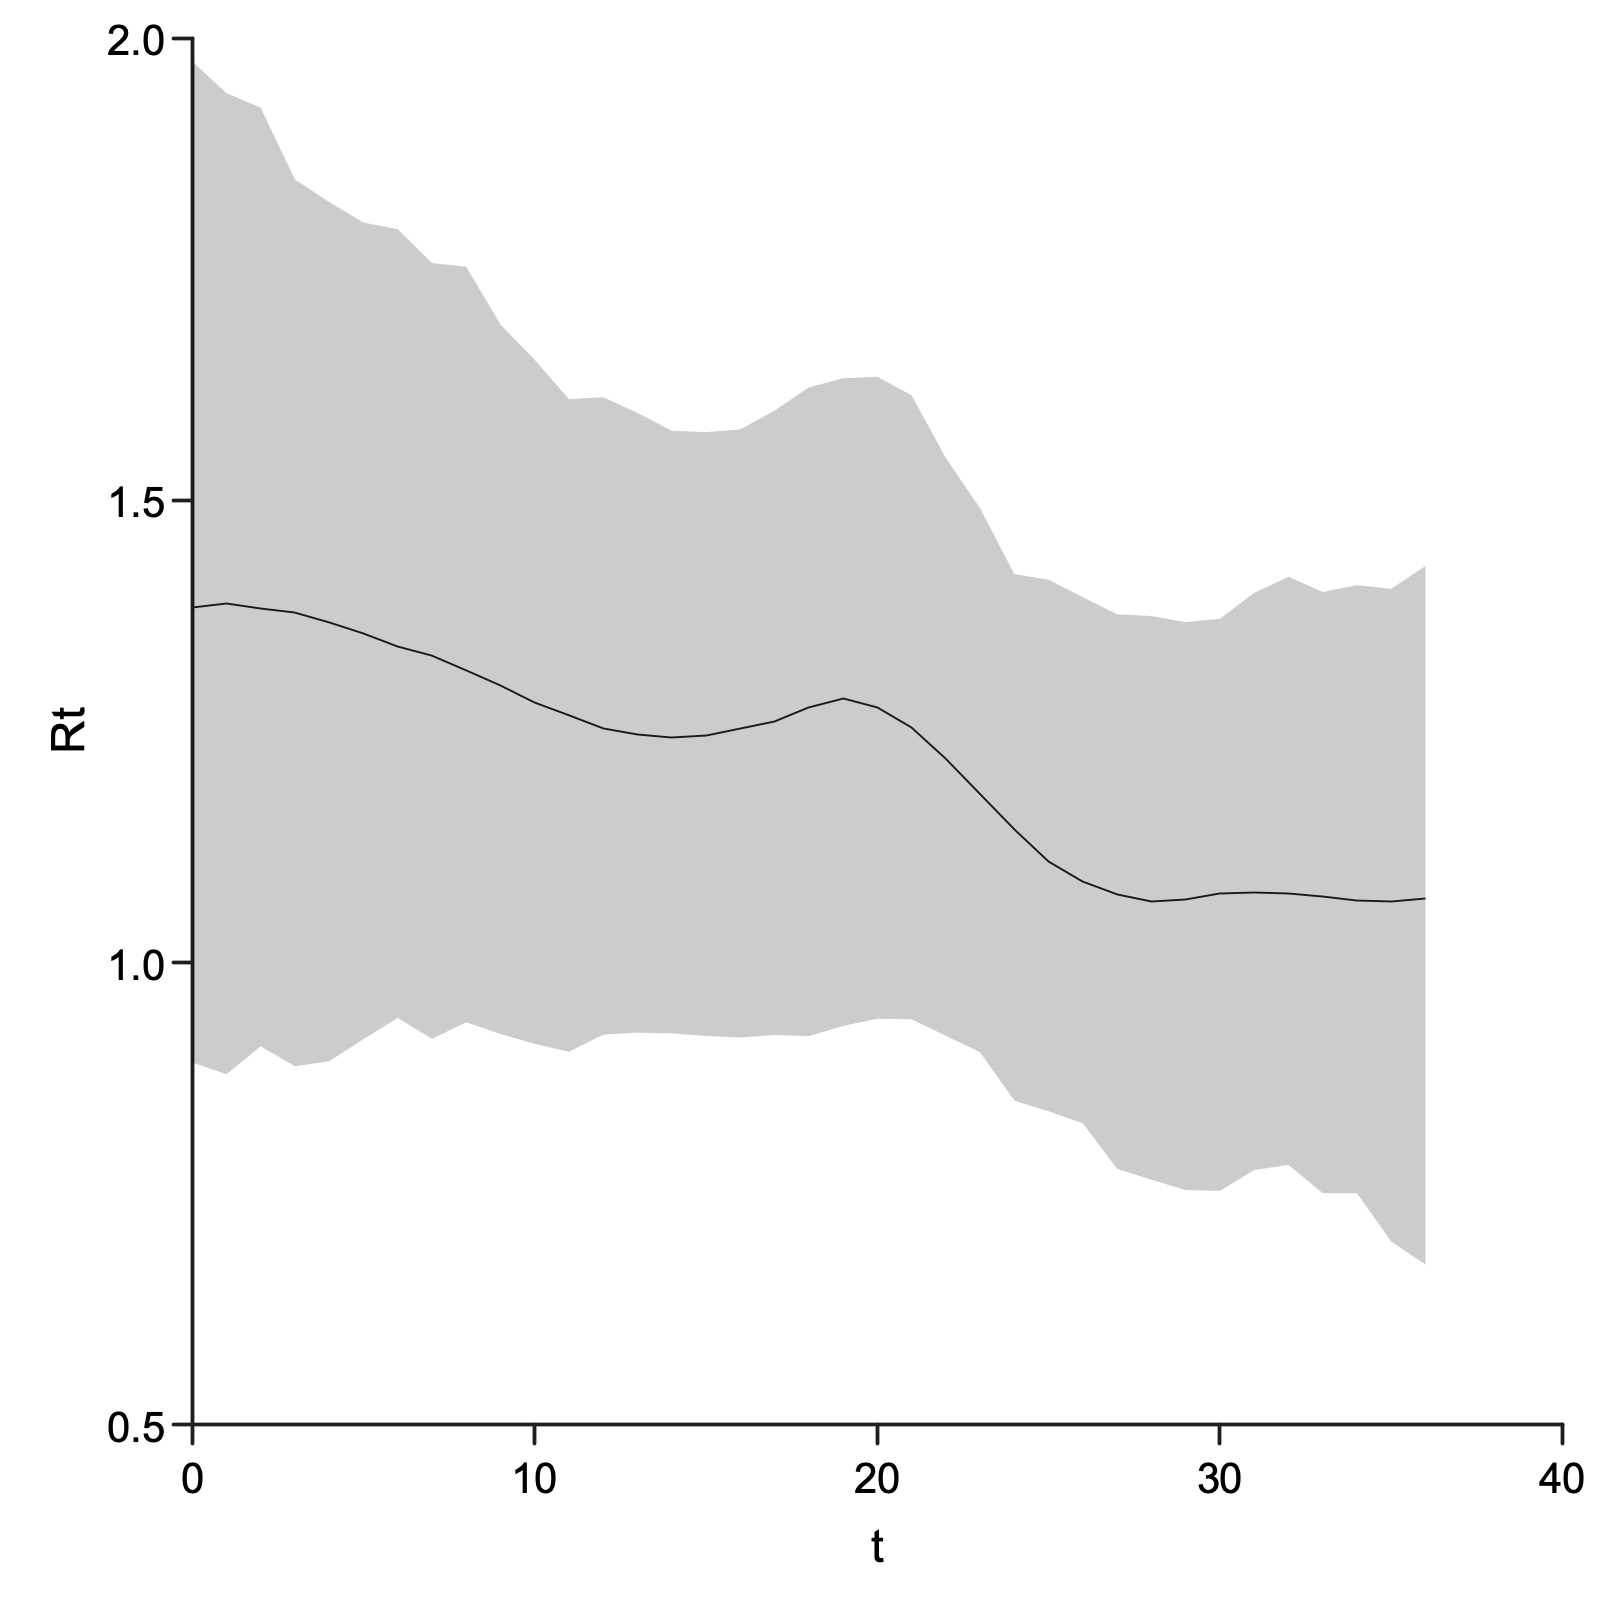

In [125]:
{{
    val countryName = "Hungary"
    val caseNumbers = countriesSmooth.collect {
        case m if m("country") == countryName => m("cases").toLong
    }
    val (rts,estimates) = predictRt(caseNumbers)
    val RtsDistributionStats(means, hdpis) = distributionStats(rts, estimates)
    show("t", "Rt", line(means), shade(hdpis))
}}

In [126]:
val countriesToPredict = countriesSmooth.map(_("country")).toSet //smaller set: Seq("Poland", "France", "Italy", "Germany", "Czechia")

countriesToPredict: Set[String] = Set(
  "Poland",
  "Croatia",
  "Luxembourg",
  "Greece",
  "Spain",
  "Russia",
  "Estonia",
  "Czechia",
  "Romania",
  "Denmark",
  "Belgium",
  "Slovenia",
  "Malta",
  "Slovakia",
  "Finland",
  "Lithuania",
  "Sweden",
  "Austria",
  "Latvia",
  "Italy",
  "Ireland",
  "Bulgaria",
  "Norway",
  "France",
  "Netherlands",
  "Switzerland",
  "Cyprus",
  "Germany",
  "Portugal",
  "Hungary"
)

In [127]:
val countryStats: Map[String, RtsDistributionStats] = {
    assert(countriesToPredict.toSet.subsetOf(countriesSmooth.map(_("country")).toSet))
    countriesToPredict.map { countryName =>
        println(countryName)
        val caseNumbers = countriesSmooth.collect {
            case m if m("country") == countryName => m("cases").toLong
        }
        val (rts,estimates) = predictRt(caseNumbers)
        val stats@RtsDistributionStats(means, hdpis) = distributionStats(rts, estimates)
//         show("t", s"Rt - $countryName", line(means), shade(hdpis))
        countryName -> stats
    }.toMap
}

Poland


Chain 1 Complete : Iteration: 1000 (3ms) Acceptance rate: 0.92 E-BFMI: 0.71 Step size: 0.03 Total gradient evaluations: 2e+05 (27us) Total time: 7s

Chain 2 Complete : Iteration: 1000 (4ms) Acceptance rate: 0.80 E-BFMI: 0.65 Step size: 0.03 Total gradient evaluations: 2e+05 (19us) Total time: 8s

Chain 3 Complete : Iteration: 1000 (3ms) Acceptance rate: 0.89 E-BFMI: 0.69 Step size: 0.03 Total gradient evaluations: 2e+05 (16us) Total time: 8s

Chain 4 Complete : Iteration: 1000 (3ms) Acceptance rate: 0.89 E-BFMI: 0.67 Step size: 0.03 Total gradient evaluations: 2e+05 (17us) Total time: 7s

Croatia


Chain 1 Complete : Iteration: 1000 (3ms) Acceptance rate: 0.86 E-BFMI: 0.70 Step size: 0.05 Total gradient evaluations: 2e+05 (15us) Total time: 7s

Chain 2 Complete : Iteration: 1000 (3ms) Acceptance rate: 0.86 E-BFMI: 0.69 Step size: 0.05 Total gradient evaluations: 2e+05 (15us) Total time: 7s

Chain 3 Complete : Iteration: 1000 (3ms) Acceptance rate: 0.86 E-BFMI: 0.68 Step size: 0.05 Total gradient evaluations: 2e+05 (18us) Total time: 6s

Chain 4 Complete : Iteration: 1000 (3ms) Acceptance rate: 0.85 E-BFMI: 0.68 Step size: 0.05 Total gradient evaluations: 2e+05 (15us) Total time: 6s

Luxembourg


Chain 1 Complete : Iteration: 1000 (4ms) Acceptance rate: 0.80 E-BFMI: 0.64 Step size: 0.04 Total gradient evaluations: 2e+05 (21us) Total time: 8s

Chain 2 Complete : Iteration: 1000 (4ms) Acceptance rate: 0.89 E-BFMI: 0.60 Step size: 0.04 Total gradient evaluations: 2e+05 (23us) Total time: 8s

Chain 3 Complete : Iteration: 1000 (5ms) Acceptance rate: 0.89 E-BFMI: 0.60 Step size: 0.04 Total gradient evaluations: 2e+05 (34us) Total time: 10s

Chain 4 Complete : Iteration: 1000 (4ms) Acceptance rate: 0.90 E-BFMI: 0.68 Step size: 0.04 Total gradient evaluations: 2e+05 (26us) Total time: 9s

Greece


Chain 1 Complete : Iteration: 1000 (6ms) Acceptance rate: 0.83 E-BFMI: 0.72 Step size: 0.05 Total gradient evaluations: 2e+05 (33us) Total time: 12s

Chain 2 Complete : Iteration: 1000 (5ms) Acceptance rate: 0.83 E-BFMI: 0.66 Step size: 0.05 Total gradient evaluations: 2e+05 (29us) Total time: 11s

Chain 3 Complete : Iteration: 1000 (5ms) Acceptance rate: 0.82 E-BFMI: 0.79 Step size: 0.05 Total gradient evaluations: 2e+05 (25us) Total time: 11s

Chain 4 Complete : Iteration: 1000 (5ms) Acceptance rate: 0.84 E-BFMI: 0.72 Step size: 0.05 Total gradient evaluations: 2e+05 (25us) Total time: 11s

Spain


Chain 1 Complete : Iteration: 1000 (6ms) Acceptance rate: 0.90 E-BFMI: 0.61 Step size: 0.009 Total gradient evaluations: 2e+05 (31us) Total time: 13s

Chain 2 Complete : Iteration: 1000 (6ms) Acceptance rate: 0.93 E-BFMI: 0.56 Step size: 0.008 Total gradient evaluations: 2e+05 (29us) Total time: 12s

Chain 3 Complete : Iteration: 1000 (6ms) Acceptance rate: 0.92 E-BFMI: 0.69 Step size: 0.008 Total gradient evaluations: 2e+05 (30us) Total time: 12s

Chain 4 Complete : Iteration: 1000 (6ms) Acceptance rate: 1.00 E-BFMI: 1.26 Step size: 0.0007 Total gradient evaluations: 2e+05 (29us) Total time: 12s

Russia


Chain 1 Complete : Iteration: 1000 (3ms) Acceptance rate: 0.90 E-BFMI: 0.58 Step size: 0.01 Total gradient evaluations: 2e+05 (21us) Total time: 8s

Chain 2 Complete : Iteration: 1000 (3ms) Acceptance rate: 0.95 E-BFMI: 0.65 Step size: 0.01 Total gradient evaluations: 2e+05 (17us) Total time: 7s

Chain 3 Complete : Iteration: 1000 (3ms) Acceptance rate: 0.84 E-BFMI: 0.60 Step size: 0.01 Total gradient evaluations: 2e+05 (17us) Total time: 8s

Chain 4 Complete : Iteration: 1000 (3ms) Acceptance rate: 0.95 E-BFMI: 0.60 Step size: 0.01 Total gradient evaluations: 2e+05 (17us) Total time: 7s

Estonia


Chain 1 Complete : Iteration: 1000 (3ms) Acceptance rate: 0.87 E-BFMI: 0.70 Step size: 0.05 Total gradient evaluations: 2e+05 (15us) Total time: 7s

Chain 2 Complete : Iteration: 1000 (3ms) Acceptance rate: 0.82 E-BFMI: 0.65 Step size: 0.06 Total gradient evaluations: 2e+05 (25us) Total time: 6s

Chain 3 Complete : Iteration: 1000 (3ms) Acceptance rate: 0.86 E-BFMI: 0.67 Step size: 0.05 Total gradient evaluations: 2e+05 (20us) Total time: 6s

Chain 4 Complete : Iteration: 1000 (3ms) Acceptance rate: 0.78 E-BFMI: 0.77 Step size: 0.06 Total gradient evaluations: 2e+05 (17us) Total time: 6s

Czechia


Chain 1 Complete : Iteration: 1000 (4ms) Acceptance rate: 0.88 E-BFMI: 0.61 Step size: 0.03 Total gradient evaluations: 2e+05 (19us) Total time: 8s

Chain 2 Complete : Iteration: 1000 (4ms) Acceptance rate: 0.87 E-BFMI: 0.66 Step size: 0.03 Total gradient evaluations: 2e+05 (19us) Total time: 8s

Chain 3 Complete : Iteration: 1000 (4ms) Acceptance rate: 0.91 E-BFMI: 0.68 Step size: 0.03 Total gradient evaluations: 2e+05 (19us) Total time: 8s

Chain 4 Complete : Iteration: 1000 (4ms) Acceptance rate: 0.88 E-BFMI: 0.55 Step size: 0.03 Total gradient evaluations: 2e+05 (19us) Total time: 8s

Romania


Chain 1 Complete : Iteration: 1000 (3ms) Acceptance rate: 0.88 E-BFMI: 0.72 Step size: 0.03 Total gradient evaluations: 2e+05 (15us) Total time: 6s

Chain 2 Complete : Iteration: 1000 (3ms) Acceptance rate: 0.90 E-BFMI: 0.70 Step size: 0.03 Total gradient evaluations: 2e+05 (15us) Total time: 6s

Chain 3 Complete : Iteration: 1000 (3ms) Acceptance rate: 0.85 E-BFMI: 0.71 Step size: 0.03 Total gradient evaluations: 2e+05 (15us) Total time: 7s

Chain 4 Complete : Iteration: 1000 (3ms) Acceptance rate: 0.79 E-BFMI: 0.71 Step size: 0.03 Total gradient evaluations: 2e+05 (16us) Total time: 6s

Denmark


Chain 1 Complete : Iteration: 1000 (4ms) Acceptance rate: 0.90 E-BFMI: 0.71 Step size: 0.03 Total gradient evaluations: 2e+05 (21us) Total time: 9s

Chain 2 Complete : Iteration: 1000 (4ms) Acceptance rate: 0.91 E-BFMI: 0.66 Step size: 0.03 Total gradient evaluations: 2e+05 (22us) Total time: 9s

Chain 3 Complete : Iteration: 1000 (4ms) Acceptance rate: 0.88 E-BFMI: 0.61 Step size: 0.03 Total gradient evaluations: 2e+05 (22us) Total time: 9s

Chain 4 Complete : Iteration: 1000 (4ms) Acceptance rate: 0.92 E-BFMI: 0.62 Step size: 0.03 Total gradient evaluations: 2e+05 (22us) Total time: 9s

Belgium


Chain 1 Complete : Iteration: 1000 (4ms) Acceptance rate: 0.92 E-BFMI: 0.60 Step size: 0.02 Total gradient evaluations: 2e+05 (24us) Total time: 9s

Chain 2 Complete : Iteration: 1000 (4ms) Acceptance rate: 0.91 E-BFMI: 0.65 Step size: 0.02 Total gradient evaluations: 2e+05 (23us) Total time: 9s

Chain 3 Complete : Iteration: 1000 (4ms) Acceptance rate: 0.92 E-BFMI: 0.64 Step size: 0.02 Total gradient evaluations: 2e+05 (22us) Total time: 9s

Chain 4 Complete : Iteration: 1000 (4ms) Acceptance rate: 0.92 E-BFMI: 0.63 Step size: 0.02 Total gradient evaluations: 2e+05 (21us) Total time: 9s

Slovenia


Chain 1 Complete : Iteration: 1000 (3ms) Acceptance rate: 0.83 E-BFMI: 0.67 Step size: 0.05 Total gradient evaluations: 2e+05 (17us) Total time: 7s

Chain 2 Complete : Iteration: 1000 (3ms) Acceptance rate: 0.80 E-BFMI: 0.72 Step size: 0.05 Total gradient evaluations: 2e+05 (17us) Total time: 7s

Chain 3 Complete : Iteration: 1000 (3ms) Acceptance rate: 0.85 E-BFMI: 0.74 Step size: 0.05 Total gradient evaluations: 2e+05 (17us) Total time: 7s

Chain 4 Complete : Iteration: 1000 (3ms) Acceptance rate: 0.82 E-BFMI: 0.62 Step size: 0.05 Total gradient evaluations: 2e+05 (23us) Total time: 7s

Malta


Chain 1 Complete : Iteration: 1000 (997us) Acceptance rate: 0.86 E-BFMI: 0.59 Step size: 0.07 Total gradient evaluations: 2e+05 (4us) Total time: 2s

Chain 2 Complete : Iteration: 1000 (999us) Acceptance rate: 0.81 E-BFMI: 0.72 Step size: 0.07 Total gradient evaluations: 2e+05 (4us) Total time: 1s

Chain 3 Complete : Iteration: 1000 (1ms) Acceptance rate: 0.84 E-BFMI: 0.68 Step size: 0.07 Total gradient evaluations: 2e+05 (4us) Total time: 1s

Chain 4 Complete : Iteration: 1000 (963us) Acceptance rate: 0.81 E-BFMI: 0.60 Step size: 0.07 Total gradient evaluations: 2e+05 (4us) Total time: 1s

Slovakia


Chain 1 Complete : Iteration: 1000 (3ms) Acceptance rate: 0.85 E-BFMI: 0.54 Step size: 0.05 Total gradient evaluations: 2e+05 (18us) Total time: 7s

Chain 2 Complete : Iteration: 1000 (3ms) Acceptance rate: 0.90 E-BFMI: 0.72 Step size: 0.04 Total gradient evaluations: 2e+05 (18us) Total time: 7s

Chain 3 Complete : Iteration: 1000 (3ms) Acceptance rate: 0.86 E-BFMI: 0.74 Step size: 0.05 Total gradient evaluations: 2e+05 (17us) Total time: 7s

Chain 4 Complete : Iteration: 1000 (3ms) Acceptance rate: 0.80 E-BFMI: 0.69 Step size: 0.06 Total gradient evaluations: 2e+05 (17us) Total time: 7s

Finland


Chain 1 Complete : Iteration: 1000 (4ms) Acceptance rate: 0.88 E-BFMI: 0.54 Step size: 0.04 Total gradient evaluations: 2e+05 (18us) Total time: 8s

Chain 2 Complete : Iteration: 1000 (4ms) Acceptance rate: 0.90 E-BFMI: 0.71 Step size: 0.04 Total gradient evaluations: 2e+05 (18us) Total time: 8s

Chain 3 Complete : Iteration: 1000 (3ms) Acceptance rate: 0.87 E-BFMI: 0.58 Step size: 0.04 Total gradient evaluations: 2e+05 (24us) Total time: 8s

Chain 4 Complete : Iteration: 1000 (4ms) Acceptance rate: 0.82 E-BFMI: 0.67 Step size: 0.04 Total gradient evaluations: 2e+05 (18us) Total time: 8s

Lithuania


Chain 1 Complete : Iteration: 1000 (2ms) Acceptance rate: 0.81 E-BFMI: 0.72 Step size: 0.06 Total gradient evaluations: 2e+05 (13us) Total time: 6s

Chain 2 Complete : Iteration: 1000 (2ms) Acceptance rate: 0.83 E-BFMI: 0.58 Step size: 0.06 Total gradient evaluations: 2e+05 (12us) Total time: 5s

Chain 3 Complete : Iteration: 1000 (2ms) Acceptance rate: 0.87 E-BFMI: 0.71 Step size: 0.05 Total gradient evaluations: 2e+05 (15us) Total time: 5s

Chain 4 Complete : Iteration: 1000 (2ms) Acceptance rate: 0.85 E-BFMI: 0.63 Step size: 0.05 Total gradient evaluations: 2e+05 (12us) Total time: 5s

Sweden


Chain 1 Complete : Iteration: 1000 (4ms) Acceptance rate: 0.87 E-BFMI: 0.63 Step size: 0.03 Total gradient evaluations: 2e+05 (25us) Total time: 9s

Chain 2 Complete : Iteration: 1000 (4ms) Acceptance rate: 0.91 E-BFMI: 0.59 Step size: 0.03 Total gradient evaluations: 2e+05 (23us) Total time: 9s

Chain 3 Complete : Iteration: 1000 (5ms) Acceptance rate: 0.88 E-BFMI: 0.68 Step size: 0.007 Total gradient evaluations: 2e+05 (28us) Total time: 10s

Chain 4 Complete : Iteration: 1000 (4ms) Acceptance rate: 0.83 E-BFMI: 0.62 Step size: 0.03 Total gradient evaluations: 2e+05 (24us) Total time: 11s

Austria


Chain 1 Complete : Iteration: 1000 (5ms) Acceptance rate: 0.94 E-BFMI: 0.62 Step size: 0.02 Total gradient evaluations: 2e+05 (26us) Total time: 12s

Chain 2 Complete : Iteration: 1000 (5ms) Acceptance rate: 0.92 E-BFMI: 0.58 Step size: 0.02 Total gradient evaluations: 2e+05 (34us) Total time: 11s

Chain 3 Complete : Iteration: 1000 (5ms) Acceptance rate: 0.92 E-BFMI: 0.66 Step size: 0.02 Total gradient evaluations: 2e+05 (39us) Total time: 11s

Chain 4 Complete : Iteration: 1000 (5ms) Acceptance rate: 0.88 E-BFMI: 0.68 Step size: 0.02 Total gradient evaluations: 2e+05 (27us) Total time: 11s

Latvia


Chain 1 Complete : Iteration: 1000 (3ms) Acceptance rate: 0.81 E-BFMI: 0.76 Step size: 0.06 Total gradient evaluations: 2e+05 (16us) Total time: 6s

Chain 2 Complete : Iteration: 1000 (3ms) Acceptance rate: 0.80 E-BFMI: 0.62 Step size: 0.06 Total gradient evaluations: 2e+05 (15us) Total time: 6s

Chain 3 Complete : Iteration: 1000 (2ms) Acceptance rate: 1.00 E-BFMI: NaN Step size: 1e-32 Total gradient evaluations: 2e+05 (14us) Total time: 6s

Chain 4 Complete : Iteration: 1000 (3ms) Acceptance rate: 0.80 E-BFMI: 0.67 Step size: 0.06 Total gradient evaluations: 2e+05 (14us) Total time: 6s

Italy


Chain 1 Complete : Iteration: 1000 (8ms) Acceptance rate: 0.92 E-BFMI: 0.66 Step size: 0.009 Total gradient evaluations: 2e+05 (41us) Total time: 16s

Chain 2 Complete : Iteration: 1000 (8ms) Acceptance rate: 0.92 E-BFMI: 0.64 Step size: 0.01 Total gradient evaluations: 2e+05 (40us) Total time: 16s

Chain 3 Complete : Iteration: 1000 (8ms) Acceptance rate: 0.95 E-BFMI: 0.59 Step size: 0.009 Total gradient evaluations: 2e+05 (40us) Total time: 16s

Chain 4 Complete : Iteration: 1000 (8ms) Acceptance rate: 0.94 E-BFMI: 0.69 Step size: 0.01 Total gradient evaluations: 2e+05 (40us) Total time: 16s

Ireland


Chain 1 Complete : Iteration: 1000 (3ms) Acceptance rate: 0.89 E-BFMI: 0.56 Step size: 0.02 Total gradient evaluations: 2e+05 (19us) Total time: 7s

Chain 2 Complete : Iteration: 1000 (5ms) Acceptance rate: 0.93 E-BFMI: 0.66 Step size: 0.02 Total gradient evaluations: 2e+05 (19us) Total time: 8s

Chain 3 Complete : Iteration: 1000 (3ms) Acceptance rate: 0.89 E-BFMI: 0.65 Step size: 0.02 Total gradient evaluations: 2e+05 (16us) Total time: 7s

Chain 4 Complete : Iteration: 1000 (3ms) Acceptance rate: 0.91 E-BFMI: 0.61 Step size: 0.02 Total gradient evaluations: 2e+05 (15us) Total time: 7s

Bulgaria


Chain 1 Complete : Iteration: 1000 (3ms) Acceptance rate: 0.83 E-BFMI: 0.57 Step size: 0.06 Total gradient evaluations: 2e+05 (15us) Total time: 7s

Chain 2 Complete : Iteration: 1000 (3ms) Acceptance rate: 0.86 E-BFMI: 0.80 Step size: 0.06 Total gradient evaluations: 2e+05 (16us) Total time: 7s

Chain 3 Complete : Iteration: 1000 (3ms) Acceptance rate: 0.85 E-BFMI: 0.65 Step size: 0.05 Total gradient evaluations: 2e+05 (16us) Total time: 7s

Chain 4 Complete : Iteration: 1000 (3ms) Acceptance rate: 0.86 E-BFMI: 0.67 Step size: 0.05 Total gradient evaluations: 2e+05 (16us) Total time: 7s

Norway


Chain 1 Complete : Iteration: 1000 (5ms) Acceptance rate: 0.89 E-BFMI: 0.71 Step size: 0.03 Total gradient evaluations: 2e+05 (25us) Total time: 10s

Chain 2 Complete : Iteration: 1000 (5ms) Acceptance rate: 0.90 E-BFMI: 0.64 Step size: 0.03 Total gradient evaluations: 2e+05 (24us) Total time: 10s

Chain 3 Complete : Iteration: 1000 (5ms) Acceptance rate: 0.90 E-BFMI: 0.75 Step size: 0.03 Total gradient evaluations: 2e+05 (24us) Total time: 10s

Chain 4 Complete : Iteration: 1000 (5ms) Acceptance rate: 0.92 E-BFMI: 0.65 Step size: 0.03 Total gradient evaluations: 2e+05 (23us) Total time: 10s

France


Chain 1 Complete : Iteration: 1000 (7ms) Acceptance rate: 0.94 E-BFMI: 0.64 Step size: 0.008 Total gradient evaluations: 2e+05 (32us) Total time: 14s

Chain 2 Complete : Iteration: 1000 (6ms) Acceptance rate: 0.84 E-BFMI: 0.61 Step size: 0.008 Total gradient evaluations: 2e+05 (35us) Total time: 14s

Chain 3 Complete : Iteration: 1000 (7ms) Acceptance rate: 0.82 E-BFMI: 0.46 Step size: 0.007 Total gradient evaluations: 2e+05 (42us) Total time: 14s

Chain 4 Complete : Iteration: 1000 (6ms) Acceptance rate: 0.96 E-BFMI: 0.54 Step size: 0.006 Total gradient evaluations: 2e+05 (32us) Total time: 14s

Netherlands


Chain 1 Complete : Iteration: 1000 (4ms) Acceptance rate: 0.91 E-BFMI: 0.62 Step size: 0.02 Total gradient evaluations: 2e+05 (21us) Total time: 9s

Chain 2 Complete : Iteration: 1000 (4ms) Acceptance rate: 0.94 E-BFMI: 0.65 Step size: 0.02 Total gradient evaluations: 2e+05 (21us) Total time: 9s

Chain 3 Complete : Iteration: 1000 (4ms) Acceptance rate: 0.88 E-BFMI: 0.71 Step size: 0.02 Total gradient evaluations: 2e+05 (23us) Total time: 9s

Chain 4 Complete : Iteration: 1000 (4ms) Acceptance rate: 0.91 E-BFMI: 0.67 Step size: 0.02 Total gradient evaluations: 2e+05 (21us) Total time: 9s

Switzerland


Chain 1 Complete : Iteration: 1000 (4ms) Acceptance rate: 0.93 E-BFMI: 0.73 Step size: 0.02 Total gradient evaluations: 2e+05 (22us) Total time: 9s

Chain 2 Complete : Iteration: 1000 (4ms) Acceptance rate: 0.86 E-BFMI: 0.64 Step size: 0.02 Total gradient evaluations: 2e+05 (20us) Total time: 9s

Chain 3 Complete : Iteration: 1000 (4ms) Acceptance rate: 0.90 E-BFMI: 0.79 Step size: 0.02 Total gradient evaluations: 2e+05 (20us) Total time: 9s

Chain 4 Complete : Iteration: 1000 (4ms) Acceptance rate: 0.92 E-BFMI: 0.67 Step size: 0.02 Total gradient evaluations: 2e+05 (21us) Total time: 9s

Cyprus


Chain 1 Complete : Iteration: 1000 (2ms) Acceptance rate: 0.82 E-BFMI: 0.60 Step size: 0.06 Total gradient evaluations: 2e+05 (10us) Total time: 4s

Chain 2 Complete : Iteration: 1000 (2ms) Acceptance rate: 0.82 E-BFMI: 0.59 Step size: 0.06 Total gradient evaluations: 2e+05 (11us) Total time: 4s

Chain 3 Complete : Iteration: 1000 (2ms) Acceptance rate: 0.85 E-BFMI: 0.71 Step size: 0.06 Total gradient evaluations: 2e+05 (10us) Total time: 4s

Chain 4 Complete : Iteration: 1000 (2ms) Acceptance rate: 0.84 E-BFMI: 0.77 Step size: 0.06 Total gradient evaluations: 2e+05 (10us) Total time: 4s

Germany


Chain 1 Complete : Iteration: 1000 (6ms) Acceptance rate: 0.91 E-BFMI: 0.57 Step size: 0.01 Total gradient evaluations: 2e+05 (31us) Total time: 14s

Chain 2 Complete : Iteration: 1000 (6ms) Acceptance rate: 0.90 E-BFMI: 0.53 Step size: 0.01 Total gradient evaluations: 2e+05 (31us) Total time: 13s

Chain 3 Complete : Iteration: 1000 (6ms) Acceptance rate: 0.93 E-BFMI: 0.57 Step size: 0.01 Total gradient evaluations: 2e+05 (30us) Total time: 13s

Chain 4 Complete : Iteration: 1000 (6ms) Acceptance rate: 0.83 E-BFMI: 0.64 Step size: 0.01 Total gradient evaluations: 2e+05 (31us) Total time: 13s

Portugal


Chain 1 Complete : Iteration: 1000 (3ms) Acceptance rate: 0.87 E-BFMI: 0.72 Step size: 0.02 Total gradient evaluations: 2e+05 (20us) Total time: 7s

Chain 2 Complete : Iteration: 1000 (3ms) Acceptance rate: 0.87 E-BFMI: 0.61 Step size: 0.02 Total gradient evaluations: 2e+05 (18us) Total time: 7s

Chain 3 Complete : Iteration: 1000 (3ms) Acceptance rate: 0.91 E-BFMI: 0.64 Step size: 0.02 Total gradient evaluations: 2e+05 (18us) Total time: 7s

Chain 4 Complete : Iteration: 1000 (3ms) Acceptance rate: 0.93 E-BFMI: 0.69 Step size: 0.02 Total gradient evaluations: 2e+05 (24us) Total time: 7s

Hungary


Chain 1 Complete : Iteration: 1000 (3ms) Acceptance rate: 0.82 E-BFMI: 0.69 Step size: 0.05 Total gradient evaluations: 2e+05 (14us) Total time: 6s

Chain 2 Complete : Iteration: 1000 (2ms) Acceptance rate: 0.86 E-BFMI: 0.66 Step size: 0.05 Total gradient evaluations: 2e+05 (13us) Total time: 5s

Chain 3 Complete : Iteration: 1000 (2ms) Acceptance rate: 0.80 E-BFMI: 0.72 Step size: 0.05 Total gradient evaluations: 2e+05 (14us) Total time: 5s

Chain 4 Complete : Iteration: 1000 (2ms) Acceptance rate: 0.92 E-BFMI: 0.74 Step size: 0.05 Total gradient evaluations: 2e+05 (15us) Total time: 5s

countryStats: Map[String, RtsDistributionStats] = Map(
  "Poland" -> RtsDistributionStats(
    Vector(
      (0, 1.936120178812351),
      (1, 1.940704241895107),
      (2, 1.9305624494498765),
      (3, 1.9138968880017393),
      (4, 1.8914351913997065),
      (5, 1.8670896518366633),
      (6, 1.8459714770863744),
      (7, 1.8146011481231838),
      (8, 1.781264839556118),
      (9, 1.7547305316904198),
      (10, 1.7217939419535009),
      (11, 1.6910060183551467),
      (12, 1.6592326806642397),
      (13, 1.632443810685662),
      (14, 1.5939913668125736),
      (15, 1.5550451951743787),
      (16, 1.5252694046078619),
      (17, 1.4970271910133852),
      (18, 1.4807936630437257),
      (19, 1.460967705608679),
      (20, 1.4235671636478198),
      (21, 1.392610493130754),
      (22, 1.349898662385658),
      (23, 1.3024701165064774),
      (24, 1.2485897350007051),
      (25, 1.1944871400481063),
      (26, 1.1440591539417873),
      (27, 1.0956127733647236),
      (28, 1.06243

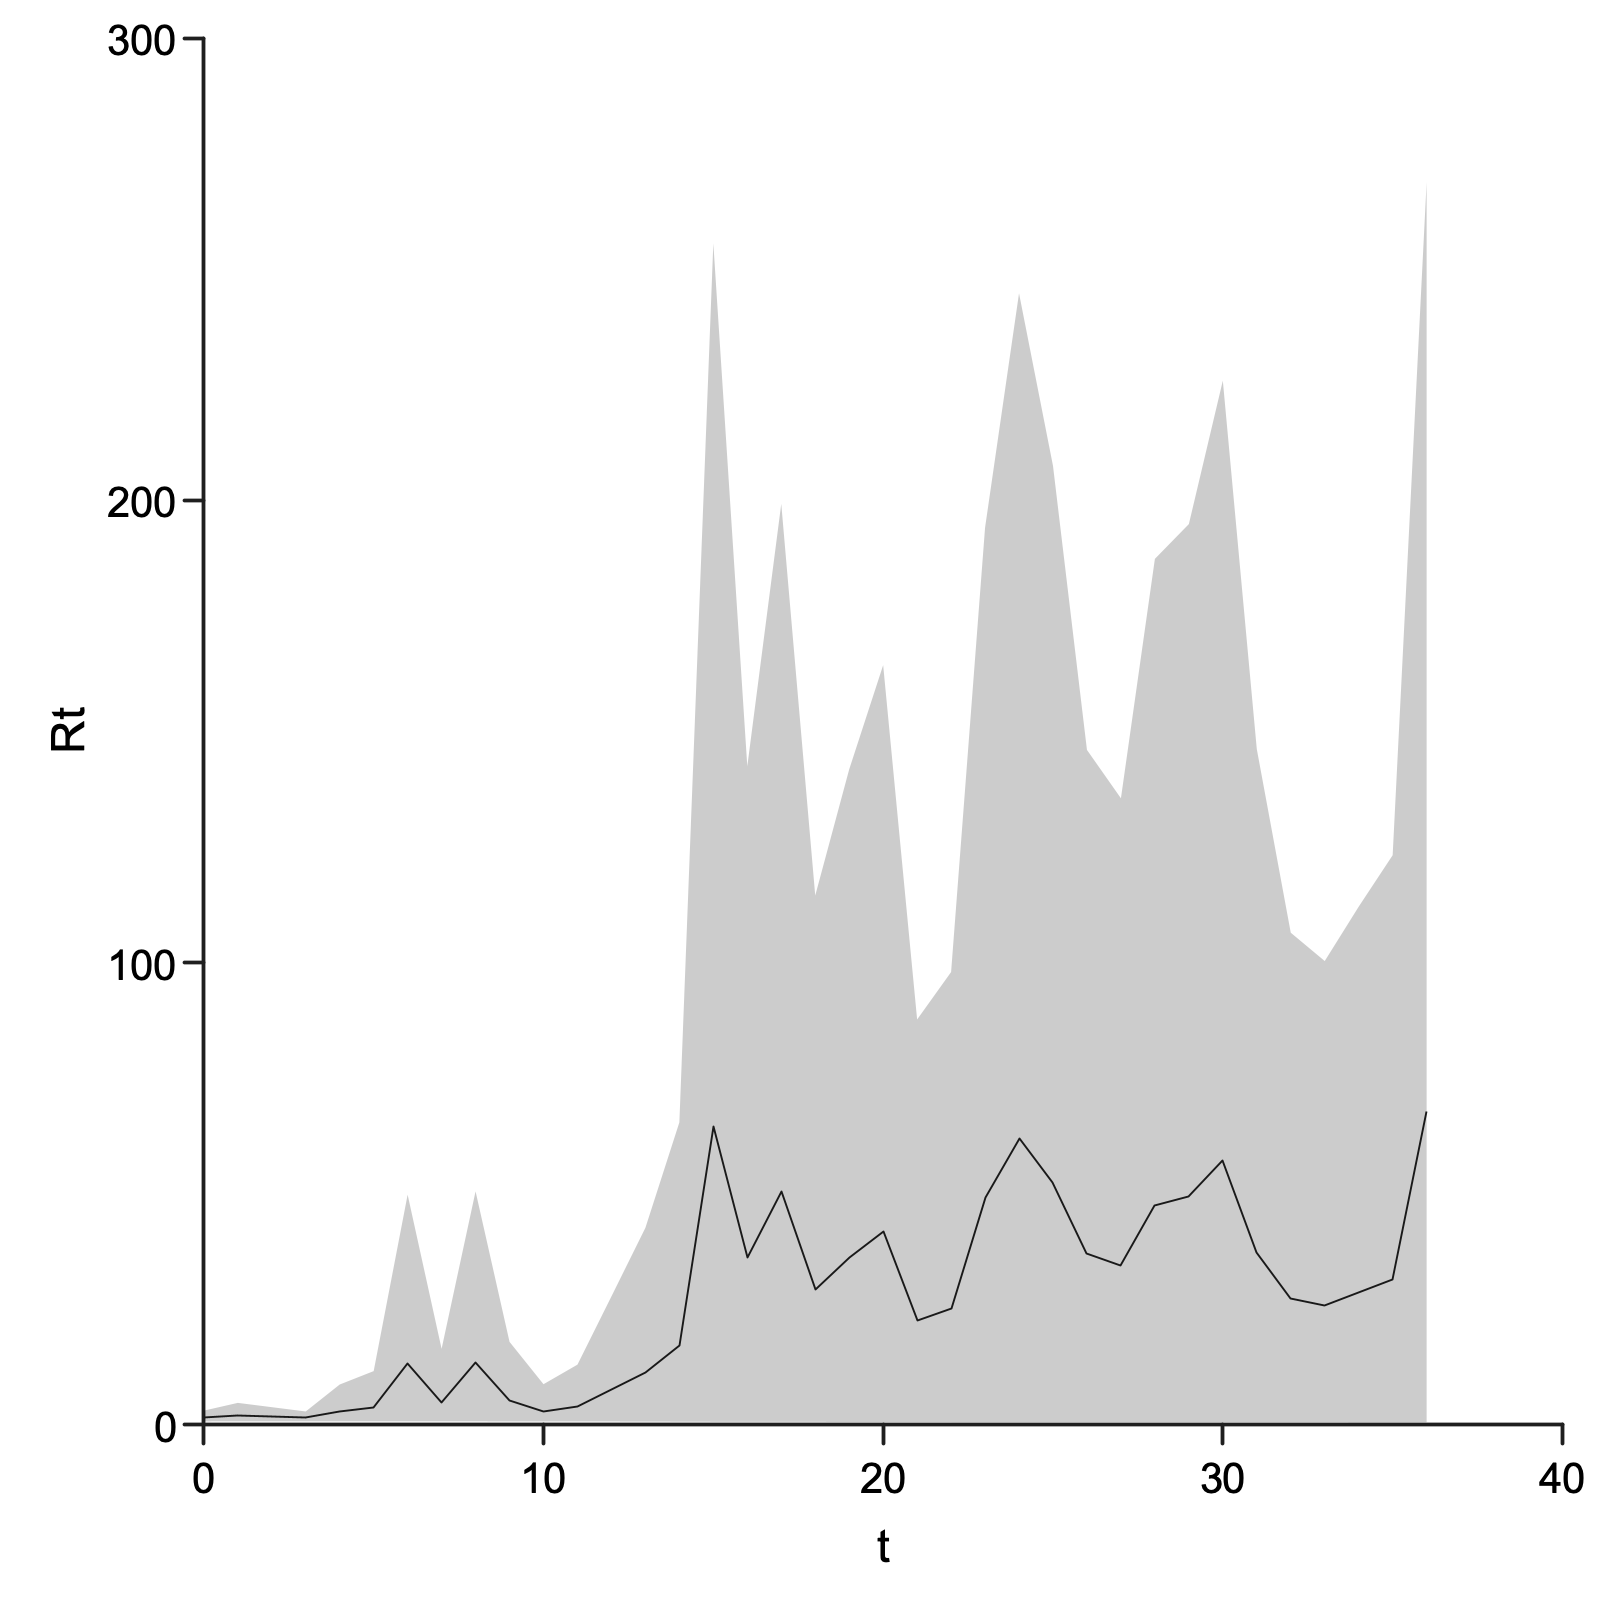

In [139]:
{{
    val RtsDistributionStats(means, hdpis) = countryStats("Latvia")
    show("t", "Rt", line(means), shade(hdpis))
}}

In [129]:
def datesForCountry(country: String) = {
    countriesSmooth.collect {
        case m if m("country") == country => m("date")
    }
}

defined function datesForCountry

In [130]:
def writeStatsToCsv(country: String, stats: RtsDistributionStats, csvWriter: CSVWriter): Unit = {
    val xs = stats.means.unzip._2 zip stats.hdpis.unzip._2
    val dates = datesForCountry(country)
    assert(xs.size == dates.size)
    (xs zip dates) foreach {
        case ((mean, (low90, high90)), date) => 
            csvWriter.writeRow(country :: date :: mean.toString :: low90.toString :: high90.toString :: Nil)
    }
}

defined function writeStatsToCsv

In [135]:
val csvWriter = CSVWriter.open(new File("data/rt-rainier.csv"))

csvWriter: CSVWriter = com.github.tototoshi.csv.CSVWriter@207c0b81

In [136]:
csvWriter.writeRow(List("country", "date", "ML", "Low_90", "High_90"))

In [137]:
countryStats.toList.sortBy(_._1).foreach {
    case (country, stats) => writeStatsToCsv(country, stats, csvWriter)
}

In [138]:
csvWriter.close()

Changes from the original model:
* run the markov process with log(R_t) to ensure that it always stays positive
* use a Laplace transition to strongly regularize
* put a prior on the std dev of the transition, rather than fixing it
* put a prior on the serial interval rather than fixing it

In [5]:
val (model, rts) =  {
    val (xs, ys) = data.unzip

    val serialInterval = Normal(5,2).latent
    val logR0 = Normal(0, 1).latent
    val sigma = Exponential(10).latent
    val diffs = Laplace(0,sigma).latentVec(data.size)
    val logRts = Vec.from(diffs.toList.scanLeft(logR0)(_ + _))
    val likelihoods = Vec.from(xs).map{case (i, kt_prev) => 
        val lambda = ((logRts(i).exp - 1)/serialInterval).exp * kt_prev
        Poisson(lambda)
    }

    (Model.observe(ys, likelihoods), logRts.map(_.exp))
}

model: Model = Model[57]
rts: Vec[Real] = Vec(
  Real(0.00, Infinity),
  Real(0.00, Infinity),
  Real(0.00, Infinity),
  Real(0.00, Infinity),
  Real(0.00, Infinity),
  Real(0.00, Infinity),
  Real(0.00, Infinity),
  Real(0.00, Infinity),
  Real(0.00, Infinity),
  Real(0.00, Infinity),
  Real(0.00, Infinity),
  Real(0.00, Infinity),
  Real(0.00, Infinity),
  Real(0.00, Infinity),
  Real(0.00, Infinity),
  Real(0.00, Infinity),
  Real(0.00, Infinity),
  Real(0.00, Infinity),
  Real(0.00, Infinity),
  Real(0.00, Infinity),
  Real(0.00, Infinity),
  Real(0.00, Infinity),
  Real(0.00, Infinity),
  Real(0.00, Infinity),
  Real(0.00, Infinity),
  Real(0.00, Infinity),
  Real(0.00, Infinity),
  Real(0.00, Infinity),
  Real(0.00, Infinity),
  Real(0.00, Infinity),
  Real(0.00, Infinity),
  Real(0.00, Infinity),
  Real(0.00, Infinity),
  Real(0.00, Infinity),
  Real(0.00, Infinity),
  Real(0.00, Infinity),
  Real(0.00, Infinity),
  Real(0.00, Infinity),
...

This seems to work best (and fastest) with a dead simple HMC(100) sampler, no mass matrix or path length adapation.

In [8]:
val samplerConfig = new DefaultConfig {
    override def massMatrixTuner() = new IdentityMassMatrixTuner
    override def sampler() = new HMCSampler(100)
}
val trace = model.sample(samplerConfig, 2)

Chain 1 Complete : Iteration: 1000 (6ms) Acceptance rate: 0.91 E-BFMI: 0.55 Step size: 0.007 Total gradient evaluations: 2e+05 (33us) Total time: 13s

Chain 2 Complete : Iteration: 1000 (6ms) Acceptance rate: 0.95 E-BFMI: 0.67 Step size: 0.006 Total gradient evaluations: 2e+05 (26us) Total time: 13s

samplerConfig: DefaultConfig{def massMatrixTuner(): com.stripe.rainier.sampler.IdentityMassMatrixTuner;def sampler(): com.stripe.rainier.sampler.HMCSampler} = ammonite.$sess.cmd7$Helper$$anon$1@7a190a17
trace: Trace = Trace[2][1000][57]

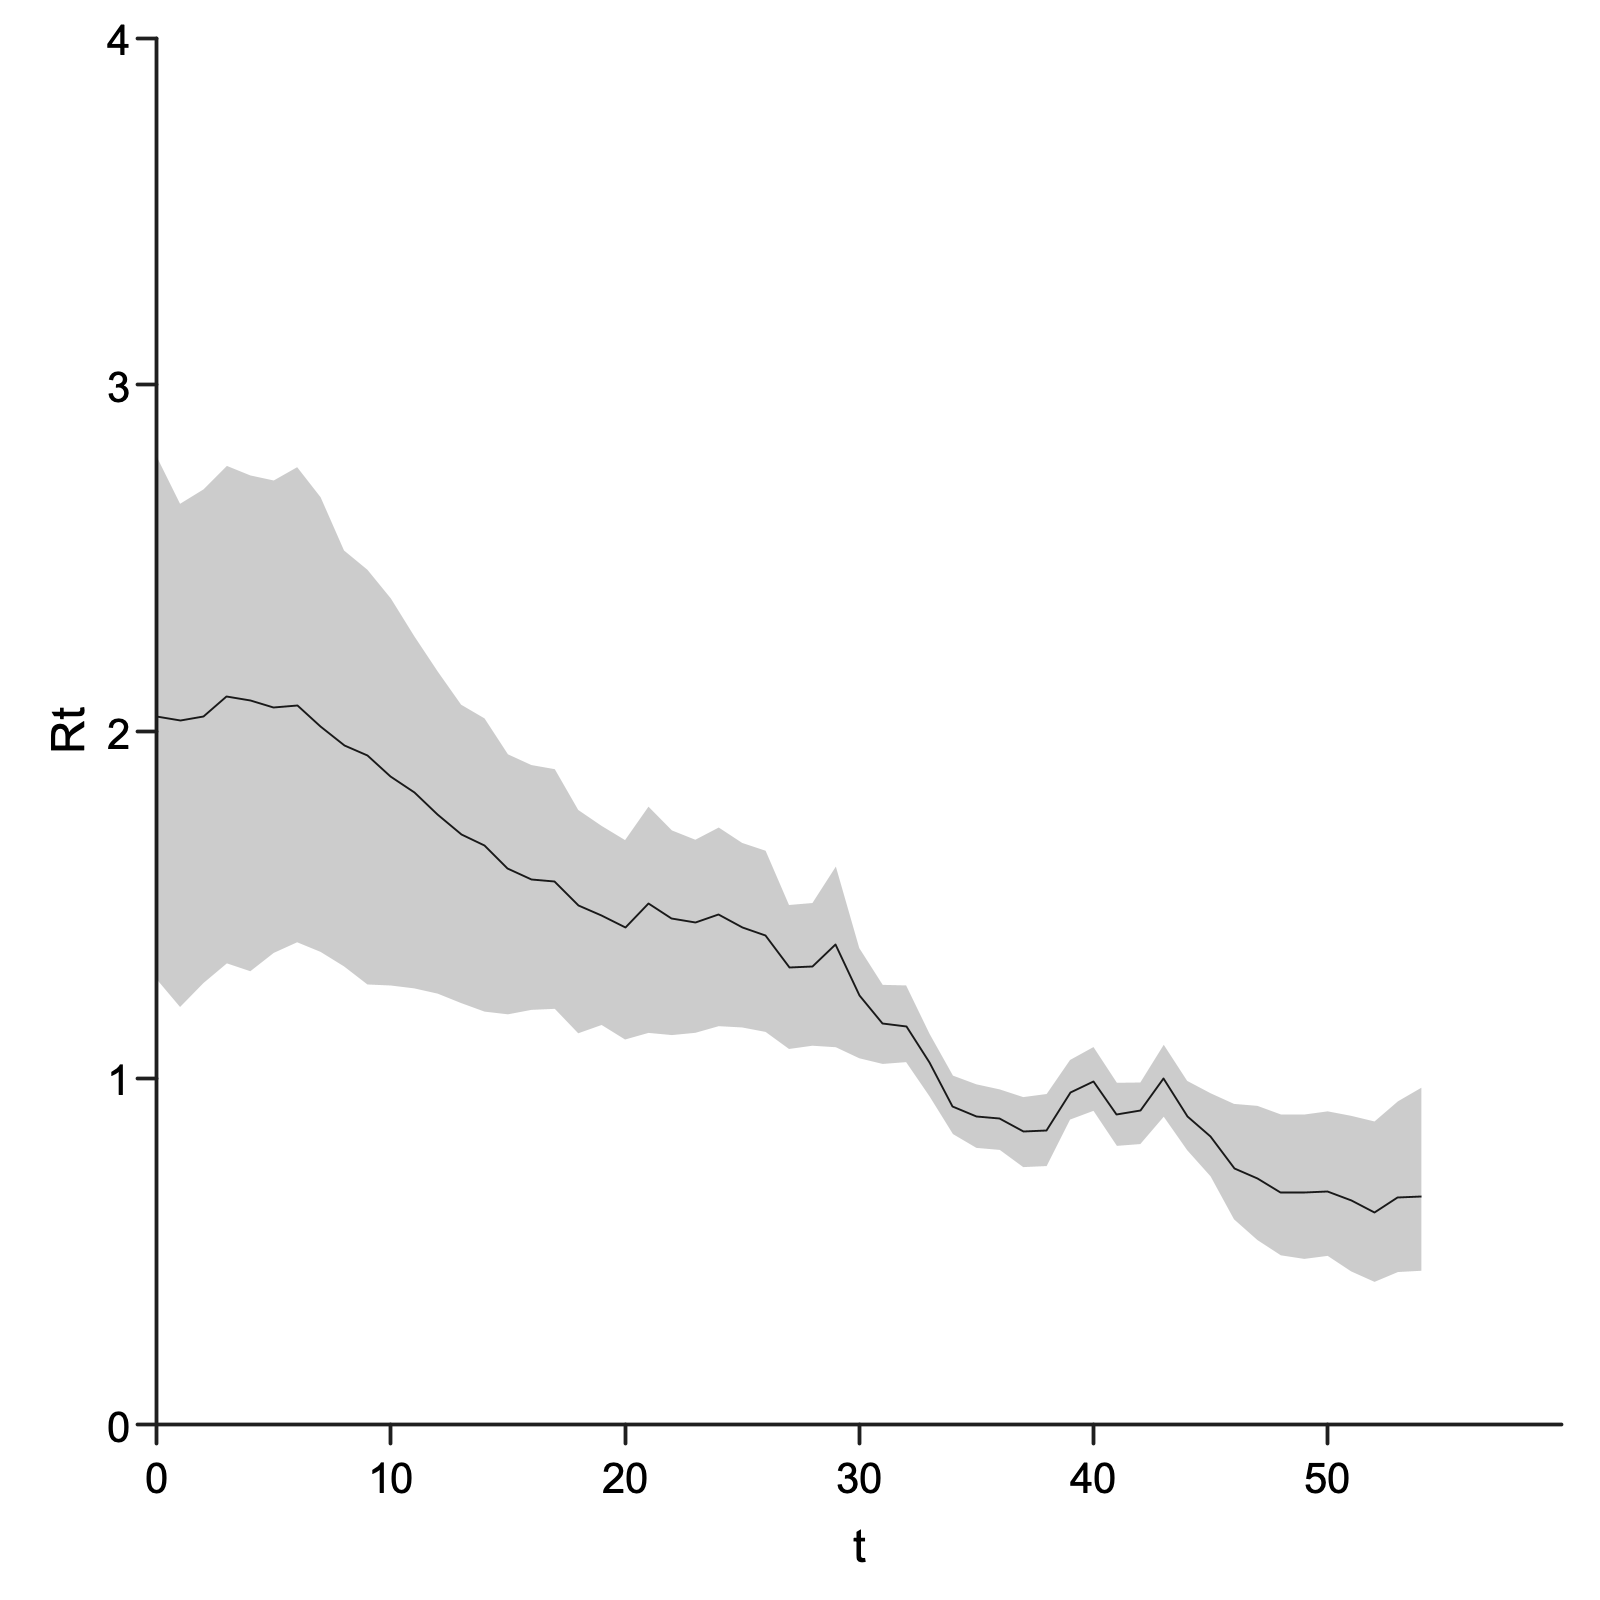

In [9]:
{{
    val rtForecasts = trace.predict(rts)
    val means = 0.until(rts.size).map{i => (i,mean(rtForecasts.map(_(i))))}
    val hdpis = 0.until(rts.size).map{i => (i, hdpi(rtForecasts.map(_(i))))}
    show("t", "Rt", line(means), shade(hdpis))
}}

In [39]:
rts

res38: Vec[Real] = Vec(
  Real(0.00, Infinity),
  Real(0.00, Infinity),
  Real(0.00, Infinity),
  Real(0.00, Infinity),
  Real(0.00, Infinity),
  Real(0.00, Infinity),
  Real(0.00, Infinity),
  Real(0.00, Infinity),
  Real(0.00, Infinity),
  Real(0.00, Infinity),
  Real(0.00, Infinity),
  Real(0.00, Infinity),
  Real(0.00, Infinity),
  Real(0.00, Infinity),
  Real(0.00, Infinity),
  Real(0.00, Infinity),
  Real(0.00, Infinity),
  Real(0.00, Infinity),
  Real(0.00, Infinity),
  Real(0.00, Infinity),
  Real(0.00, Infinity),
  Real(0.00, Infinity),
  Real(0.00, Infinity),
  Real(0.00, Infinity),
  Real(0.00, Infinity),
  Real(0.00, Infinity),
  Real(0.00, Infinity),
  Real(0.00, Infinity),
  Real(0.00, Infinity),
  Real(0.00, Infinity),
  Real(0.00, Infinity),
  Real(0.00, Infinity),
  Real(0.00, Infinity),
  Real(0.00, Infinity),
  Real(0.00, Infinity),
  Real(0.00, Infinity),
  Real(0.00, Infinity),
  Real(0.00, Infinity),
...